## random forest regression model for predicting price

In [83]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm

In [84]:
X = pd.read_json('../data/model_data/X.json')
y = pd.read_json('../data/model_data/y.json', typ='series')

## some data cleaning

In [85]:
# one-hot-encode categorical features
X_encoded = pd.get_dummies(X)
X_float = X.select_dtypes(include=np.number)
X = pd.concat([X_float, X_encoded], axis=1)

In [86]:
# impute np.nan values with numerical sentinel 
imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value = -999)
X = imp.fit_transform(X)

In [87]:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=4)

In [88]:
# oops -- impute singular 0 value by mean imputation
y_test[1576] = np.mean(y_test)

## hyperparameter selection

In [89]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [90]:
def calc_metrics(y_true, y_pred):
    price_pred = np.exp(y_pred)
    price_true = np.exp(y_true).to_numpy()
    
    mape = mean_absolute_percentage_error(price_true, price_pred)
    rmsle = mean_squared_error(y_true, y_pred, squared=False)
    rmse = mean_squared_error(price_true, price_pred, squared=False)
    
    return mape, rmsle, rmse

In [91]:
# random search for hyperparameter selection
m_list, n_list = [], []
for i in range(100):
        m_list.append(random.randint(1, 50))
        n_list.append(random.randint(1, 20))

m_list.sort()

values = list(zip(m_list, n_list))

In [ ]:
# 5-fold cross-validation 
cv_scores = []
for m_, n_ in tqdm(values):
    rf = RandomForestRegressor(max_features=m_, n_estimators=n_, random_state=42, criterion='mse')
    scores = -cross_val_score(rf, X, y, scoring='neg_mean_squared_error') # default: k=5
    cv_scores.append(scores.mean())
    
m, n = values[np.argmin(cv_scores)]
print('optimal values:', (m, n))
print('performance:', np.min(cv_scores))

In [ ]:
# evaluate on test data
rf = RandomForestRegressor(max_features=m, n_estimators=n, random_state=42)
rf.fit(X_tr, y_tr)

# sort in ascending order to detect possible bias
idx = list(np.argsort(y_test))

y_test = pd.Series(y_test.to_numpy()[idx])
X_test = X_test[idx]

y_pred = rf.predict(X_test)

## metrics and error visualization

In [82]:
mape, rmsle, rmse = calc_metrics(y_test, y_pred)

print('MAPE:', str(mape) + '%')
print('RMSLE:', str(rmsle))
print('RMSE:', rmse)

MAPE: 71.27630227576151%
RMSLE: 0.2947503897832102
RMSE: 446.02004171437466


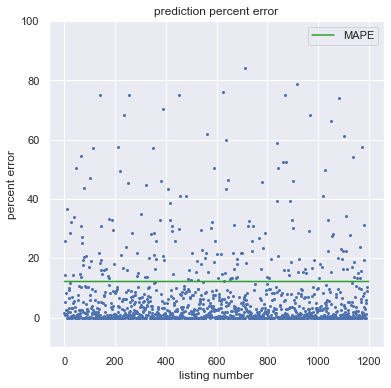

In [61]:
# visualize errors
import matplotlib.pyplot as plt
import seaborn as sns

price_pred = np.exp(y_pred)
price_true = np.exp(y_test.to_numpy())

sns.set(style='darkgrid')
plt.subplots(figsize=(6,6))
plt.plot(np.abs(price_pred - price_true) / price_true * 100, 'o', markersize=2)
plt.plot(np.arange(1200), [mape] * 1200, label='MAPE', color='#2ca02c')
plt.title('prediction percent error')
plt.ylim(-10, 100) # note: some outliers are not visible
plt.ylabel('percent error')
plt.xlabel('listing number')
plt.legend()
plt.savefig('error.png', dpi=300)

## permutation importance

look at these links here:
[explanation](https://scikit-learn.org/stable/modules/permutation_importance.html),
[implementation](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py)

In [60]:
## start here!


